In [1]:
from vnpy.event import EventEngine
from vnpy.trader.engine import MainEngine
from vnpy.trader.ui import MainWindow, create_qapp
from vnpy.gateway.okex import OkexGateway
from vnpy.app.cta_strategy import CtaStrategyApp
from vnpy.app.cta_backtester import CtaBacktesterApp
from vnpy.app.data_manager import DataManagerApp
from vnpy.app.data_recorder import DataRecorderApp
from vnpy.trader.constant import Exchange
from vnpy.trader.object import TickData
from vnpy.trader.database import database_manager
import os
import sys
import csv
import datetime
import pandas as pd
from vnpy.app.cta_strategy.backtesting import BacktestingEngine, OptimizationSetting
from vnpy.app.cta_strategy.base import BacktestingMode
from vnpy.app.cta_strategy.strategies.atr_rsi_strategy import AtrRsiStrategy
from strategies.test import TestStrategy


class MyTickData(TickData):
    
    def __init__(self,*args,**kargs):
        self.custom_field = kargs['custom_field']
        del(kargs['custom_field'])
        TickData.__init__(self,*args,**kargs)


cols = ['timestamp']
for i in range(20):
    cols += ["ap{}".format(i+1),"aq{}".format(i+1)]
for i in range(20):
    cols += ["bp{}".format(i+1),"bq{}".format(i+1)]

data = pd.read_csv("/Users/ww/mm/BTCUSDT_2021_5_19/0/depth.csv",names=cols,date_parser=lambda x:pd.to_datetime(x,unit='ms'),parse_dates=['timestamp'])
data['custom_field'] = (data['ap1']+data['bp1'])/2
data = data.apply(lambda item:MyTickData(
                symbol="BTC",
                custom_field=item['custom_field'],
                datetime=item['timestamp'],
                exchange=Exchange.BINANCE,
                bid_price_1=float(item["bp1"]),
                bid_volume_1=float(item["bq1"]),
                ask_price_1=float(item["ap1"]),
                ask_volume_1=float(item["aq1"]), 
                ask_price_2=float(item['ap2']),
                ask_price_3=float(item['ap3']),
                ask_price_4=float(item['ap4']),
                ask_price_5=float(item['ap5']),
                bid_price_2=float(item['bp2']),
                bid_price_3=float(item['bp3']),
                bid_price_4=float(item['bp4']),
                bid_price_5=float(item['bp5']),
                ask_volume_2=float(item['aq2']),
                ask_volume_3=float(item['aq3']),
                ask_volume_4=float(item['aq4']),
                ask_volume_5=float(item['aq5']),
                bid_volume_2=float(item['bq2']),
                bid_volume_3=float(item['bq3']),
                bid_volume_4=float(item['bq4']),
                bid_volume_5=float(item['bq5']),
                gateway_name="DB",       
),axis=1)


In [16]:
pd.set_option('mode.chained_assignment', None)
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
def calculate_trades_result(trades):
    """
    Deal with trade data
    """
    dt, direction, offset, price, volume = [], [], [], [], []
    for i in trades.values():
        dt.append(i.datetime)
        direction.append(i.direction.value)
        offset.append(i.offset.value)
        price.append(i.price)
        volume.append(i.volume)
    # Generate DataFrame with datetime, direction, offset, price, volume
    df = pd.DataFrame()
    df["direction"] = direction
    df["offset"] = offset
    df["price"] = price
    df["volume"] = volume
    df["current_time"] = dt
    df["last_time"] = df["current_time"].shift(1)
    # Calculate trade amount
    df["amount"] = df["price"] * df["volume"]
    df["acum_amount"] = df["amount"].cumsum()
    # Calculate pos, net pos(with direction), acumluation pos(with direction)
    def calculate_pos(df):
        if df["direction"] == "多":
            result = df["volume"]
        else:
            result = - df["volume"]
        return result
    df["pos"] = df.apply(calculate_pos, axis=1)
    df["net_pos"] = df["pos"].cumsum()
    df["acum_pos"] = df["volume"].cumsum()
    # Calculate trade result, acumulation result
    # ej: trade result(buy->sell) means (new price - old price) * volume
    df["result"] = -1 * df["pos"] * df["price"]
    df["acum_result"] = df["result"].cumsum()
    # Filter column data when net pos comes to zero
    def get_acum_trade_result(df):
        if df["net_pos"] == 0:
            return df["acum_result"]
    df["acum_trade_result"] = df.apply(get_acum_trade_result, axis=1)
    def get_acum_trade_volume(df):
        if df["net_pos"] == 0:
            return df["acum_pos"]
    df["acum_trade_volume"] = df.apply(get_acum_trade_volume, axis=1)   
    def get_acum_trade_duration(df):
        if df["net_pos"] == 0:
            return df["current_time"] - df["last_time"]
    df["acum_trade_duration"] = df.apply(get_acum_trade_duration, axis=1)  
    def get_acum_trade_amount(df):
        if df["net_pos"] == 0:
            return df["acum_amount"]
    df["acum_trade_amount"] = df.apply(get_acum_trade_amount, axis=1) 
    # Select row data with net pos equil to zero     
    df = df.dropna()
    return df
def generate_trade_df(trades, size, rate, slippage, capital):
    """
    Calculate trade result from increment
    """
    df = calculate_trades_result(trades)
    trade_df = pd.DataFrame()
    trade_df["close_direction"] = df["direction"]
    trade_df["close_time"] = df["current_time"]
    trade_df["close_price"] = df["price"]
    trade_df["pnl"] = df["acum_trade_result"] - \
        df["acum_trade_result"].shift(1).fillna(0)
    trade_df["volume"] = df["acum_trade_volume"] - \
        df["acum_trade_volume"].shift(1).fillna(0)
    trade_df["duration"] = df["current_time"] - \
        df["last_time"]
    trade_df["turnover"] = df["acum_trade_amount"] - \
        df["acum_trade_amount"].shift(1).fillna(0)
    trade_df["commission"] = trade_df["turnover"] * rate
    trade_df["slipping"] = trade_df["volume"] * size * slippage
    trade_df["net_pnl"] = trade_df["pnl"] - \
        trade_df["commission"] - trade_df["slipping"]
    result = calculate_base_net_pnl(trade_df, capital)
    return result
def calculate_base_net_pnl(df, capital):
    """
    Calculate statistic base on net pnl
    """
    df["acum_pnl"] = df["net_pnl"].cumsum()
    df["balance"] = df["acum_pnl"] + capital
    df["return"] = np.log(
        df["balance"] / df["balance"].shift(1)
        ).fillna(0)
    df["highlevel"] = (
        df["balance"].rolling(
            min_periods=1, window=len(df), center=False).max()
    )
    df["drawdown"] = df["balance"] - df["highlevel"]
    df["ddpercent"] = df["drawdown"] / df["highlevel"] * 100
    df.reset_index(drop=True, inplace=True)
    return df
def buy2sell(df, capital):
    """
    Generate DataFrame with only trade from buy to sell
    """
    buy2sell = df[df["close_direction"] == "空"]
    result = calculate_base_net_pnl(buy2sell, capital)
    return result
def short2cover(df, capital):
    """
    Generate DataFrame with only trade from short to cover
    """
    short2cover = df[df["close_direction"] == "多"]
    result = calculate_base_net_pnl(short2cover, capital)
    return result
def statistics_trade_result(df, capital, show_chart=True):
    """"""
    end_balance = df["balance"].iloc[-1]
    max_drawdown = df["drawdown"].min()
    max_ddpercent = df["ddpercent"].min()
    pnl_medio = df["net_pnl"].mean()
    trade_count = len(df)
    duration_medio = df["duration"].mean().total_seconds()/3600
    commission_medio = df["commission"].mean()
    slipping_medio = df["slipping"].mean()
    win = df[df["net_pnl"] > 0]
    win_amount = win["net_pnl"].sum()
    win_pnl_medio = win["net_pnl"].mean()
    win_duration_medio = win["duration"].mean().total_seconds()/3600
    win_count = len(win)
    loss = df[df["net_pnl"] < 0]
    loss_amount = loss["net_pnl"].sum()
    loss_pnl_medio = loss["net_pnl"].mean()
    loss_duration_medio = loss["duration"].mean().total_seconds()/3600
    loss_count = len(loss)
    winning_rate = win_count / trade_count
    win_loss_pnl_ratio = - win_pnl_medio / loss_pnl_medio
    total_return = (end_balance / capital - 1) * 100
    return_drawdown_ratio = -total_return / max_ddpercent
    output(f"起始资金：\t{capital:,.2f}")
    output(f"结束资金：\t{end_balance:,.2f}")
    output(f"总收益率：\t{total_return:,.2f}%")
    output(f"最大回撤: \t{max_drawdown:,.2f}")
    output(f"百分比最大回撤: {max_ddpercent:,.2f}%")
    output(f"收益回撤比：\t{return_drawdown_ratio:,.2f}")
    output(f"总成交次数:\t{trade_count}")
    output(f"盈利成交次数:\t{win_count}")
    output(f"亏损成交次数:\t{loss_count}")
    output(f"胜率:\t\t{winning_rate:,.2f}")
    output(f"盈亏比:\t\t{win_loss_pnl_ratio:,.2f}")
    output(f"平均每笔盈亏:\t{pnl_medio:,.2f}")
    output(f"平均持仓小时:\t{duration_medio:,.2f}")
    output(f"平均每笔手续费:\t{commission_medio:,.2f}")
    output(f"平均每笔滑点:\t{slipping_medio:,.2f}")
    output(f"总盈利金额:\t{win_amount:,.2f}")
    output(f"盈利交易均值:\t{win_pnl_medio:,.2f}")
    output(f"盈利持仓小时:\t{win_duration_medio:,.2f}")
    output(f"总亏损金额:\t{loss_amount:,.2f}")
    output(f"亏损交易均值:\t{loss_pnl_medio:,.2f}")
    output(f"亏损持仓小时:\t{loss_duration_medio:,.2f}")
    if not show_chart:
        return
    plt.figure(figsize=(10, 12))
    acum_pnl_plot = plt.subplot(3, 1, 1)
    acum_pnl_plot.set_title("Balance Plot")
    plt.plot(df['balance'])
    # df["balance"].plot(legend=True)
    pnl_plot = plt.subplot(3, 1, 2)
    pnl_plot.set_title("Pnl Per Trade")
    plt.plot(df["net_pnl"])
    distribution_plot = plt.subplot(3, 1, 3)
    distribution_plot.set_title("Trade Pnl Distribution")
    plt.hist(df["net_pnl"])
    plt.show()
def output(msg):
    """
    Output message with datetime.
    """
    print(f"{datetime.now()}\t{msg}")
def exhaust_trade_result(
    trades, 
    size: int = 10, 
    rate: float = 0.0, 
    slippage: float = 0.0, 
    capital: int = 1000000,
    show_long_short_condition=True
    ):
    """
    Exhaust all trade result.
    """
    total_trades = generate_trade_df(trades, size, rate, slippage, capital)
    statistics_trade_result(total_trades, capital)
    if not show_long_short_condition:
        return
    long_trades = buy2sell(total_trades, capital)
    short_trades = short2cover(total_trades, capital)
    output("-----------------------")
    output("纯多头交易")
    statistics_trade_result(long_trades, capital)
    output("-----------------------")
    output("纯空头交易")
    statistics_trade_result(short_trades, capital)

In [13]:
engine = BacktestingEngine()
engine.set_parameters(
    vt_symbol="BTC.BINANCE",
    interval="1m",
    start=datetime.datetime(2020,5,19),
    end=datetime.datetime(2021,5,22),
    rate=0.5/10000,
    slippage=5,
    size=.1,
    pricetick=5,
    capital=100000,
    mode=BacktestingMode.TICK,
)
engine.add_strategy(TestStrategy,{})
engine.history_data = data

In [14]:
engine.run_backtesting()

test strategy init
2021-06-07 01:24:39.472135	策略初始化完成
test strategy start
2021-06-07 01:24:39.472837	开始回放历史数据
2021-06-07 01:24:39.511932	回放进度：= [0%]
2021-06-07 01:24:39.549862	回放进度：== [10%]
2021-06-07 01:24:39.584957	回放进度：=== [20%]
2021-06-07 01:24:39.616731	回放进度：==== [30%]
2021-06-07 01:24:39.648631	回放进度：===== [40%]
2021-06-07 01:24:39.679726	回放进度：====== [50%]
2021-06-07 01:24:39.710365	回放进度：======= [60%]
2021-06-07 01:24:39.741908	回放进度：======== [70%]
2021-06-07 01:24:39.777876	回放进度：========= [80%]
2021-06-07 01:24:39.817350	回放进度：========== [90%]
2021-06-07 01:24:39.817737	回放进度：=========== [100%]
2021-06-07 01:24:39.817774	历史数据回放结束


2021-06-07 01:26:02.156237	起始资金：	1,000,000.00
2021-06-07 01:26:02.156352	结束资金：	999,562.73
2021-06-07 01:26:02.156370	总收益率：	-0.04%
2021-06-07 01:26:02.156395	最大回撤: 	-445.43
2021-06-07 01:26:02.156411	百分比最大回撤: -0.04%
2021-06-07 01:26:02.156425	收益回撤比：	-0.98
2021-06-07 01:26:02.156438	总成交次数:	7130
2021-06-07 01:26:02.156474	盈利成交次数:	2510
2021-06-07 01:26:02.156511	亏损成交次数:	4563
2021-06-07 01:26:02.156531	胜率:		0.35
2021-06-07 01:26:02.156547	盈亏比:		1.32
2021-06-07 01:26:02.156563	平均每笔盈亏:	-0.06
2021-06-07 01:26:02.156579	平均持仓小时:	0.00
2021-06-07 01:26:02.156594	平均每笔手续费:	0.00
2021-06-07 01:26:02.156610	平均每笔滑点:	0.00
2021-06-07 01:26:02.156624	总盈利金额:	1,162.29
2021-06-07 01:26:02.156637	盈利交易均值:	0.46
2021-06-07 01:26:02.156649	盈利持仓小时:	0.00
2021-06-07 01:26:02.156661	总亏损金额:	-1,599.56
2021-06-07 01:26:02.156673	亏损交易均值:	-0.35
2021-06-07 01:26:02.156688	亏损持仓小时:	0.00


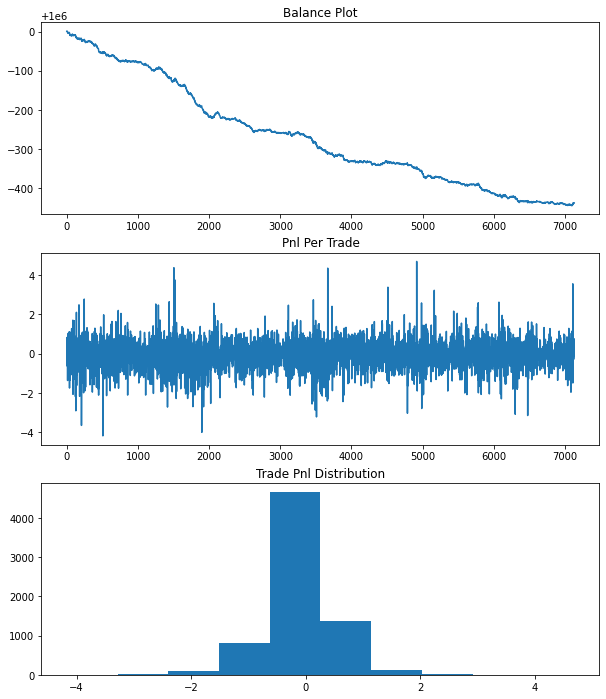

2021-06-07 01:26:02.803126	-----------------------
2021-06-07 01:26:02.803211	纯多头交易
2021-06-07 01:26:02.808665	起始资金：	1,000,000.00
2021-06-07 01:26:02.808811	结束资金：	999,844.47
2021-06-07 01:26:02.808851	总收益率：	-0.02%
2021-06-07 01:26:02.808880	最大回撤: 	-161.09
2021-06-07 01:26:02.808903	百分比最大回撤: -0.02%
2021-06-07 01:26:02.808924	收益回撤比：	-0.97
2021-06-07 01:26:02.808944	总成交次数:	3268
2021-06-07 01:26:02.808968	盈利成交次数:	1147
2021-06-07 01:26:02.808985	亏损成交次数:	2085
2021-06-07 01:26:02.809004	胜率:		0.35
2021-06-07 01:26:02.809025	盈亏比:		1.40
2021-06-07 01:26:02.809048	平均每笔盈亏:	-0.05
2021-06-07 01:26:02.809061	平均持仓小时:	0.00
2021-06-07 01:26:02.809073	平均每笔手续费:	0.00
2021-06-07 01:26:02.809085	平均每笔滑点:	0.00
2021-06-07 01:26:02.809096	总盈利金额:	524.65
2021-06-07 01:26:02.809108	盈利交易均值:	0.46
2021-06-07 01:26:02.809119	盈利持仓小时:	0.00
2021-06-07 01:26:02.809130	总亏损金额:	-680.19
2021-06-07 01:26:02.809142	亏损交易均值:	-0.33
2021-06-07 01:26:02.809153	亏损持仓小时:	0.00


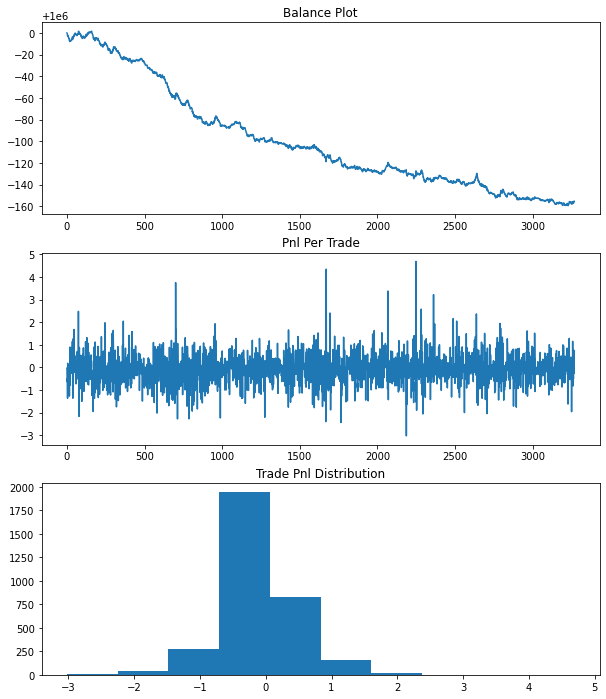

2021-06-07 01:26:03.499513	-----------------------
2021-06-07 01:26:03.499863	纯空头交易
2021-06-07 01:26:03.506907	起始资金：	1,000,000.00
2021-06-07 01:26:03.507012	结束资金：	999,718.26
2021-06-07 01:26:03.507029	总收益率：	-0.03%
2021-06-07 01:26:03.507047	最大回撤: 	-289.97
2021-06-07 01:26:03.507061	百分比最大回撤: -0.03%
2021-06-07 01:26:03.507073	收益回撤比：	-0.97
2021-06-07 01:26:03.507085	总成交次数:	3862
2021-06-07 01:26:03.507103	盈利成交次数:	1363
2021-06-07 01:26:03.507116	亏损成交次数:	2478
2021-06-07 01:26:03.507129	胜率:		0.35
2021-06-07 01:26:03.507155	盈亏比:		1.26
2021-06-07 01:26:03.507177	平均每笔盈亏:	-0.07
2021-06-07 01:26:03.507201	平均持仓小时:	0.00
2021-06-07 01:26:03.507218	平均每笔手续费:	0.00
2021-06-07 01:26:03.507232	平均每笔滑点:	0.00
2021-06-07 01:26:03.507245	总盈利金额:	637.64
2021-06-07 01:26:03.507257	盈利交易均值:	0.47
2021-06-07 01:26:03.507268	盈利持仓小时:	0.00
2021-06-07 01:26:03.507279	总亏损金额:	-919.38
2021-06-07 01:26:03.507290	亏损交易均值:	-0.37
2021-06-07 01:26:03.507304	亏损持仓小时:	0.00


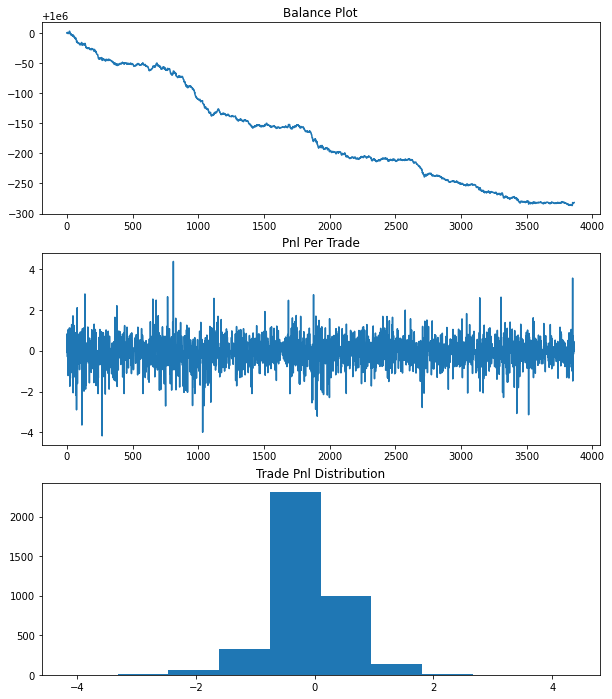

In [17]:
exhaust_trade_result(engine.trades)

In [13]:
df = engine.calculate_result()

2021-06-05 01:14:55.875803	开始计算逐日盯市盈亏
2021-06-05 01:14:55.914858	逐日盯市盈亏计算完成


In [5]:
engine.calculate_statistics()

2021-06-04 23:58:22.291440	开始计算策略统计指标
2021-06-04 23:58:22.306773	------------------------------
2021-06-04 23:58:22.306865	首个交易日：	2021-05-18
2021-06-04 23:58:22.306926	最后交易日：	2021-05-18
2021-06-04 23:58:22.307017	总交易日：	1
2021-06-04 23:58:22.307105	盈利交易日：	0
2021-06-04 23:58:22.307140	亏损交易日：	1
2021-06-04 23:58:22.307198	起始资金：	100,000.00
2021-06-04 23:58:22.307230	结束资金：	98,492.66
2021-06-04 23:58:22.307501	总收益率：	-1.51%
2021-06-04 23:58:22.307531	年化收益：	-361.76%
2021-06-04 23:58:22.307567	最大回撤: 	0.00
2021-06-04 23:58:22.307601	百分比最大回撤: 0.00%
2021-06-04 23:58:22.307621	最长回撤天数: 	0
2021-06-04 23:58:22.307823	总盈亏：	-1,507.34
2021-06-04 23:58:22.307855	总手续费：	308.38
2021-06-04 23:58:22.308063	总滑点：	713.05
2021-06-04 23:58:22.308118	总成交金额：	6,167,536.31
2021-06-04 23:58:22.308166	总成交笔数：	14261
2021-06-04 23:58:22.308199	日均盈亏：	-1,507.34
2021-06-04 23:58:22.308225	日均手续费：	308.38
2021-06-04 23:58:22.308448	日均滑点：	713.05
2021-06-04 23:58:22.308505	日均成交金额：	6,167,536.31
2021-06-04 23:58:22.308628	日均成交笔数：	1426

{'start_date': datetime.date(2021, 5, 18),
 'end_date': datetime.date(2021, 5, 18),
 'total_days': 1,
 'profit_days': 0,
 'loss_days': 1,
 'capital': 100000,
 'end_balance': 98492.6580846851,
 'max_drawdown': 0.0,
 'max_ddpercent': 0.0,
 'max_drawdown_duration': 0,
 'total_net_pnl': -1507.341915314903,
 'daily_net_pnl': -1507.341915314903,
 'total_commission': 308.3768153150014,
 'daily_commission': 308.3768153150014,
 'total_slippage': 713.0499999998992,
 'daily_slippage': 713.0499999998992,
 'total_turnover': 6167536.306300003,
 'daily_turnover': 6167536.306300003,
 'total_trade_count': 14261,
 'daily_trade_count': 14261.0,
 'total_return': -1.507341915314897,
 'annual_return': -361.7620596755753,
 'daily_return': 0.0,
 'return_std': 0.0,
 'sharpe_ratio': 0.0,
 'return_drawdown_ratio': 0}

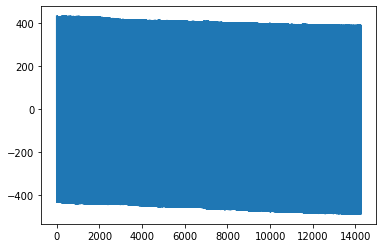

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.array(df.iloc[0]['trading_pnls']).cumsum())

In [19]:
np.array(df.iloc[0]['trading_pnls']).cumsum()

array([ 4.300000e+02, -1.000000e-04,  4.299907e+02, ...,  3.879915e+02,
       -4.829670e+01, -4.845974e+02])

In [22]:
engine.trades.values()

=0.1, datetime=Timestamp('2021-05-18 16:59:41.070000')), TradeData(gateway_name='BACKTESTING', symbol='BTC', exchange=<Exchange.BINANCE: 'BINANCE'>, orderid='14187', tradeid='14187', direction=<Direction.LONG: '多'>, offset=<Offset.OPEN: '开'>, price=43641.44, volume=0.1, datetime=Timestamp('2021-05-18 16:59:41.321000')), TradeData(gateway_name='BACKTESTING', symbol='BTC', exchange=<Exchange.BINANCE: 'BINANCE'>, orderid='14188', tradeid='14188', direction=<Direction.SHORT: '空'>, offset=<Offset.CLOSE: '平'>, price=43644.91, volume=0.1, datetime=Timestamp('2021-05-18 16:59:41.572000')), TradeData(gateway_name='BACKTESTING', symbol='BTC', exchange=<Exchange.BINANCE: 'BINANCE'>, orderid='14189', tradeid='14189', direction=<Direction.SHORT: '空'>, offset=<Offset.CLOSE: '平'>, price=43641.43, volume=0.1, datetime=Timestamp('2021-05-18 16:59:41.823000')), TradeData(gateway_name='BACKTESTING', symbol='BTC', exchange=<Exchange.BINANCE: 'BINANCE'>, orderid='14190', tradeid='14190', direction=<Directi